## DvXray Classification Training Notebook  
Multi-label Image Classification using ResNet-18 (PyTorch + MPS GPU)

This notebook trains a **multi-label classifier** for the DvXray baggage security dataset.
It uses the dataset created by the preprocessing pipeline:




Each sample contains:
- `sampleID_OL.png`
- `sampleID_SD.png`
- `sampleID.npy` (multi-hot vector, 15 classes)

The notebook includes:
- Dataset loader  
- Train/validation split  
- ResNet18 model  
- Multi-label BCE loss  
- F1-score evaluation  
- Mac MPS GPU support


In [1]:
import os
import numpy as np
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import torchvision.models as models

from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

# Auto device detection (CUDA or MPS or CPU)
def get_device():
    if torch.cuda.is_available():
        print("Using CUDA 🟩")
        return torch.device("cuda")
    elif torch.backends.mps.is_available():
        print("Using Apple Metal GPU (MPS) 🍎")
        return torch.device("mps")
    else:
        print("Using CPU 🟥")
        return torch.device("cpu")

device = get_device()
device


Using Apple Metal GPU (MPS) 🍎


device(type='mps')

### DvXray Classification Dataset Loader  
Each sample contains:
- One OL image
- One SD image
- A `.npy` file with a 15-dim vector  

This loader loads the **OL image** as input and the multi-hot label vector.


In [3]:
class XRayClassificationDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root = root_dir
        self.transform = transform

        # sampleID = before "_OL.png" or "_SD.png"
        self.sample_ids = sorted({f.split("_")[0] for f in os.listdir(root_dir) if f.endswith(".png")})

    def __len__(self):
        return len(self.sample_ids)

    def __getitem__(self, idx):
        sid = self.sample_ids[idx]

        img_path = os.path.join(self.root, f"{sid}_OL.png")
        label_path = os.path.join(self.root, f"{sid}.npy")

        img = Image.open(img_path).convert("RGB")
        label = np.load(label_path).astype("float32")

        if self.transform:
            img = self.transform(img)

        return img, torch.tensor(label)


### Transform Steps  
- Resize → 256×256  
- Convert to Tensor  
- Normalize  


In [4]:
transform = T.Compose([
    T.Resize((256, 256)),
    T.ToTensor(),
    T.Normalize(mean=[0.5]*3, std=[0.5]*3)
])


### Load Training & Validation Sets  
This uses the dataset created by your full processing pipeline.


In [5]:
from torch.utils.data import random_split, DataLoader

train_dir = "data/processed/classification/train"
val_dir   = "data/processed/classification/val"

# -----------------------------
# 1. Load datasets
# -----------------------------
train_ds = XRayClassificationDataset(train_dir, transform)
val_ds   = XRayClassificationDataset(val_dir, transform)

print("Original Validation samples:", len(val_ds))

# # -----------------------------
# # 2. Split val → new_val + test
# # -----------------------------
# val_size = int(len(val_ds) * 0.8)         # 80% for validation
# test_size = len(val_ds) - val_size        # 20% for test

# val_ds, test_ds = random_split(val_ds, [val_size, test_size])

# print("New Validation samples:", len(val_ds))
# print("Test samples:", len(test_ds))

# -----------------------------
# 3. Create DataLoaders
# -----------------------------
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False)
# test_loader  = DataLoader(test_ds, batch_size=32, shuffle=False)


Original Validation samples: 3200


### Visualize a Training Sample


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

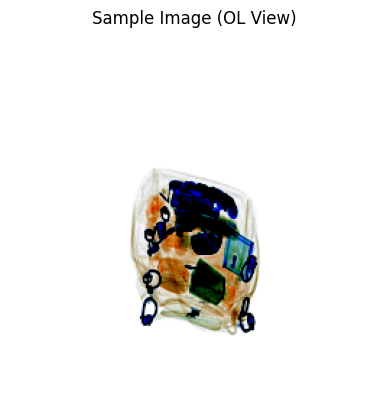

In [6]:
img, label = train_ds[100]

plt.imshow(img.permute(1,2,0))
plt.title("Sample Image (OL View)")
plt.axis("off")

label


### Model: ResNet-18 (Multi-label)  
We modify the final FC layer to output **15 classes**.


In [7]:
from torchvision.models import ResNet18_Weights

num_classes = 15

model = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, num_classes)

model.to(device)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Loss & Optimizer  
- Multi-label → `BCEWithLogitsLoss`  
- Optimizer → AdamW  


In [8]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

### Training Loop  
Runs one epoch:
- Forward  
- Loss  
- Backprop  
- Optimizer step  


In [9]:
def train_one_epoch(epoch):
    model.train()
    total_loss = 0

    for imgs, labels in train_loader:
        imgs = imgs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        logits = model(imgs)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1} - Train Loss: {total_loss:.4f}")


### Validation  
Computes:
- Loss  
- F1 Score (micro-average)  


In [11]:
from sklearn.metrics import f1_score, average_precision_score
import numpy as np
import pandas as pd

# If you have class names:
CLASS_NAMES = [
    'Gun','Knife','Wrench','Pliers','Scissors','Lighter','Battery',
    'Bat','Razor_blade','Saw_blade','Fireworks','Hammer',
    'Screwdriver','Dart','Pressure_vessel'
]

def validate(epoch):
    model.eval()
    preds_all = []
    labels_all = []
    probs_all = []
    total_loss = 0

    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs = imgs.to(device)
            labels = labels.to(device)

            logits = model(imgs)
            loss = criterion(logits, labels)
            total_loss += loss.item()

            probs = torch.sigmoid(logits)              
            preds = (probs > 0.5).float()              

            preds_all.append(preds.cpu().numpy())
            labels_all.append(labels.cpu().numpy())
            probs_all.append(probs.cpu().numpy())

    preds_all = np.vstack(preds_all)
    labels_all = np.vstack(labels_all)
    probs_all = np.vstack(probs_all)

    # -------------------------------
    # MICRO F1
    # -------------------------------
    f1 = f1_score(labels_all, preds_all, average="micro")

    # -------------------------------
    # PER-CLASS AP
    # -------------------------------
    n_classes = labels_all.shape[1]
    class_APs = []

    for c in range(n_classes):
        ap = average_precision_score(labels_all[:, c], probs_all[:, c])
        class_APs.append(ap)

    # mAP = mean across classes
    mAP = np.mean(class_APs)

    # -------------------------------
    # PRINT SUMMARY
    # -------------------------------
    print(
        f"Epoch {epoch+1} | Val Loss: {total_loss:.4f} "
        f"| F1: {f1:.4f} | mAP: {mAP:.4f}"
    )

    # -------------------------------
    # PRINT PER-CLASS AP TABLE
    # -------------------------------
    # pair class names with APs
    table = list(zip(CLASS_NAMES, class_APs))

    # sort: highest AP first
    table = sorted(table, key=lambda x: x[1], reverse=True)

    print("\n===== PER-CLASS AP (sorted) =====")
    for cls, ap in table:
        print(f"{cls:15s}  AP: {ap:.4f}")
    print("=================================\n")
    
    # pd.DataFrame({"class": CLASS_NAMES, "AP": class_APs}).to_csv("per_class_AP_epoch_%d.csv" % epoch)


    return f1, mAP, class_APs


### Train Classification Model  

In [12]:
epochs = 20

mAP_history = []
f1_history = []   # optional

for epoch in range(epochs):
    train_one_epoch(epoch)
    f1, mAP, _ = validate(epoch)
    
    mAP_history.append(mAP)
    f1_history.append(f1)  # optional

torch.save(model.state_dict(), "xray_resnet18_cls.pth")
print("Model saved → xray_resnet18_cls.pth")

Epoch 1 - Train Loss: 45.2200
Epoch 1 | Val Loss: 6.9099 | F1: 0.2781 | mAP: 0.5088

===== PER-CLASS AP (sorted) =====
Bat              AP: 0.9988
Hammer           AP: 0.9459
Gun              AP: 0.8255
Pliers           AP: 0.7166
Wrench           AP: 0.7012
Battery          AP: 0.6258
Pressure_vessel  AP: 0.5161
Lighter          AP: 0.4422
Saw_blade        AP: 0.4106
Knife            AP: 0.2865
Scissors         AP: 0.2512
Screwdriver      AP: 0.2448
Dart             AP: 0.2390
Razor_blade      AP: 0.2189
Fireworks        AP: 0.2094

Epoch 2 - Train Loss: 18.0404
Epoch 2 | Val Loss: 4.1404 | F1: 0.6590 | mAP: 0.7260

===== PER-CLASS AP (sorted) =====
Bat              AP: 0.9997
Hammer           AP: 0.9831
Pliers           AP: 0.9132
Wrench           AP: 0.9114
Pressure_vessel  AP: 0.8867
Gun              AP: 0.8835
Battery          AP: 0.8320
Saw_blade        AP: 0.7358
Scissors         AP: 0.6968
Screwdriver      AP: 0.5928
Knife            AP: 0.5724
Lighter          AP: 0.5645
Dart 

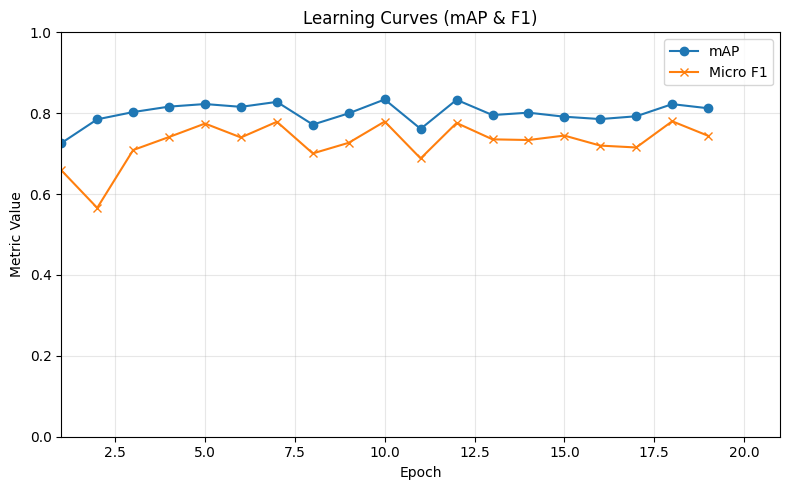

In [13]:
plt.figure(figsize=(8,5))
plt.plot(mAP_history, marker='o', label='mAP')
plt.plot(f1_history, marker='x', label='Micro F1')
plt.xlim(1, epochs+1)
plt.ylim(0, 1)
plt.xlabel("Epoch")
plt.ylabel("Metric Value")
plt.title("Learning Curves (mAP & F1)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("metrics_curve.png", dpi=150)
plt.show()

## Test the positive image

Random positive sample index (subset): 3144
Sample ID: P04710


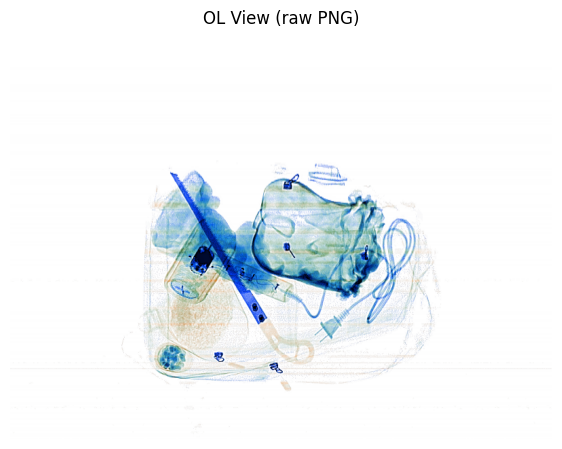

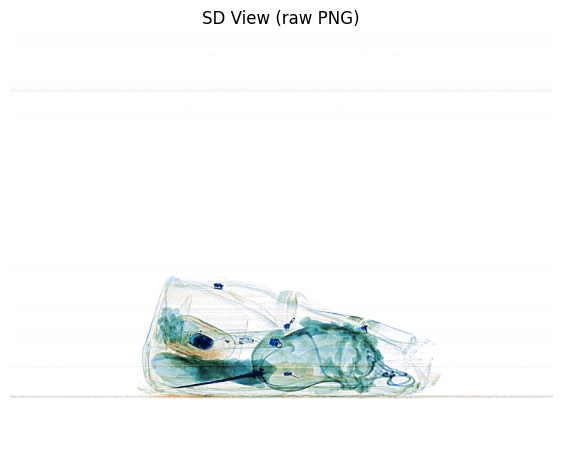


===== SINGLE-IMAGE AP (mAP) =====
OL     AP: 1.0000
SD     AP: 0.2000
FUSED  AP: 1.0000

===== CLASS PROBABILITIES (OL | SD | FUSED) =====
Gun             | OL=0.000 | SD=0.948 | FUSED=0.948
Knife           | OL=0.102 | SD=0.000 | FUSED=0.102
Wrench          | OL=0.000 | SD=0.000 | FUSED=0.000
Pliers          | OL=0.000 | SD=0.000 | FUSED=0.000
Scissors        | OL=0.000 | SD=0.000 | FUSED=0.000
Lighter         | OL=0.000 | SD=0.000 | FUSED=0.000
Battery         | OL=0.000 | SD=0.004 | FUSED=0.004
Bat             | OL=0.000 | SD=0.000 | FUSED=0.000
Razor_blade     | OL=0.000 | SD=0.000 | FUSED=0.000
Saw_blade       | OL=0.949 | SD=0.000 | FUSED=0.949
Fireworks       | OL=0.000 | SD=0.000 | FUSED=0.000
Hammer          | OL=0.000 | SD=0.000 | FUSED=0.000
Screwdriver     | OL=0.002 | SD=0.000 | FUSED=0.002
Dart            | OL=0.000 | SD=0.000 | FUSED=0.000
Pressure_vessel | OL=0.000 | SD=0.000 | FUSED=0.000


In [16]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image
import torchvision.transforms as T
from sklearn.metrics import average_precision_score
import random

# ===================================================
# 1) PICK A RANDOM POSITIVE SAMPLE IN THE SUBSET
# ===================================================
positive_indices = [i for i in range(len(val_ds)) if val_ds[i][1].sum() > 0]

if len(positive_indices) == 0:
    raise ValueError("No positive sample found in validation set!")

pos_idx = random.choice(positive_indices)
print("Random positive sample index (subset):", pos_idx)

# ===================================================
# 2) GET ORIGINAL DATASET INDEX + SAMPLE ID
# ===================================================
# Since val_ds is NOT a Subset, pos_idx IS the original index
orig_idx = pos_idx

# Dataset has attribute sample_ids
sid = val_ds.sample_ids[orig_idx]
print("Sample ID:", sid)

# ===================================================
# 3) LOAD OL IMAGE RAW FROM DISK (FOR VISUALIZATION)
# ===================================================
# ⚠ FIX THIS PATH IF NEEDED
OL_FOLDER = "data/processed/classification/val"
ol_path = f"{OL_FOLDER}/{sid}_OL.png"

raw_ol = Image.open(ol_path).convert("RGB")

plt.figure(figsize=(7,6))
plt.title("OL View (raw PNG)")
plt.imshow(raw_ol)
plt.axis("off")
plt.show()

# ===================================================
# 4) GET NORMALIZED TENSOR FOR OL INFERENCE
# ===================================================
# val_ds[pos_idx] returns (normalized_tensor, label)
img_ol, gt_label = val_ds[pos_idx]

model.eval()
ol_inp = img_ol.unsqueeze(0).to(device)

with torch.no_grad():
    logits_ol = model(ol_inp)[0]
    probs_ol = torch.sigmoid(logits_ol).cpu()
    pred_ol = (probs_ol > 0.5).float()

# ===================================================
# 5) LOAD SD RAW PNG FOR VISUALIZATION
# ===================================================
SD_FOLDER = "data/processed/classification/val"    # ⚠ FIX IF DIFFERENT
sd_path = f"{SD_FOLDER}/{sid}_SD.png"

raw_sd = Image.open(sd_path).convert("RGB")

plt.figure(figsize=(7,6))
plt.title("SD View (raw PNG)")
plt.imshow(raw_sd)
plt.axis("off")
plt.show()

# ===================================================
# 6) MAKE NORMALIZED TENSOR FOR SD INFERENCE
# ===================================================
transform = T.Compose([
    T.Resize((224,224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

img_sd_tensor = transform(raw_sd)
sd_inp = img_sd_tensor.unsqueeze(0).to(device)

with torch.no_grad():
    logits_sd = model(sd_inp)[0]
    probs_sd = torch.sigmoid(logits_sd).cpu()
    pred_sd = (probs_sd > 0.5).float()

# ===================================================
# 7) FUSION (MAX RULE)
# ===================================================
probs_fused = torch.max(probs_ol, probs_sd)
pred_fused = (probs_fused > 0.5).float()

# ===================================================
# 8) SINGLE-IMAGE AP (mAP)
# ===================================================
gt = gt_label.numpy()

ap_ol    = average_precision_score(gt, probs_ol.numpy())
ap_sd    = average_precision_score(gt, probs_sd.numpy())
ap_fused = average_precision_score(gt, probs_fused.numpy())

print("\n===== SINGLE-IMAGE AP (mAP) =====")
print(f"OL     AP: {ap_ol:.4f}")
print(f"SD     AP: {ap_sd:.4f}")
print(f"FUSED  AP: {ap_fused:.4f}")

# ===================================================
# 9) PRINT CLASSWISE PROBABILITIES
# ===================================================
class_names = [
    'Gun','Knife','Wrench','Pliers','Scissors','Lighter','Battery','Bat',
    'Razor_blade','Saw_blade','Fireworks','Hammer','Screwdriver','Dart','Pressure_vessel'
]

print("\n===== CLASS PROBABILITIES (OL | SD | FUSED) =====")
for i, name in enumerate(class_names):
    print(f"{name:15s} | OL={probs_ol[i]:.3f} | SD={probs_sd[i]:.3f} | FUSED={probs_fused[i]:.3f}")

# print("\nGT Label Vector:\n", gt_label)
# print("\nPred Label (OL):\n", pred_ol)
# print("\nPred Label (SD):\n", pred_sd)
# print("\nPred Label (FUSED):\n", pred_fused)
